# T23_G8 - 01 - Import

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

pd.set_option('display.max.columns', None)

import pyreadstat

## Reading Codebook

* I just want to make sure that I understand the relationship between the codebook and the datafile.

In [2]:
# Read in codebook (all worksheets - first three letters (in lowercase) give name of data file.)
xls = pd.ExcelFile("orig/docs/T23_G8_Codebook.xlsx")
xls.sheet_names

['BCGM8', 'BSAM8', 'BSGM8', 'BSPM8', 'BSRM8', 'BSTM8', 'BTMM8', 'BTSM8']

In [3]:
# Compiled from User Guide T23 User Guide, (exhibit 2.4, p.52)
DATAFILES = {
    'bcg': 'School context data',
    'bsa': 'Student achievement data',
    'bsp': 'Student process data',
    'bsr': 'Within-country scoring reliability data',
    'bsg': 'Student context data data',
    'bst': 'Student achievement data',
    'btm': 'Mathematics teacher context data',
    'bts': 'Science teacher context data (we will ignore this)',
}

### Check: codebook matches datafiles

Iterating over all worksheets:

* Verify that variables (columns) in data file matches variables (rows) in codebook worksheet.
* Print size of datafile (I was curious).

In [4]:
for work_sheet in xls.sheet_names:

    datafile = work_sheet[:3].lower()
    print(f"Datafile: {datafile} : {DATAFILES[datafile]} ...")

    # Load codebook and datafile
    df_codebook = pd.read_excel(xls, sheet_name=work_sheet)
    df_data = pd.read_spss(f"orig/SPSS/{datafile}irlm8.sav")
 
    # Extract variable names from codebook and datafile
    variables_in_codebook = df_codebook.Variable.values.tolist()
    variables_in_datafile = df_data.columns.tolist()

    # Sneaky peak into datafile    
    print(f"\t Shape:   {df_data.shape}")
    print(f"\t Columns: {df_data.columns.tolist()[:10]}")

    # Demand variables in codebook and in datafile match
    assert variables_in_codebook==variables_in_datafile, "Mismatch between codebook and datafile for data file type {datafile}"

Datafile: bcg : School context data ...
	 Shape:   (153, 104)
	 Columns: ['CTY', 'IDCNTRY', 'IDPOP', 'IDGRADER', 'IDGRADE', 'IDSCHOOL', 'ITLANG_CQ', 'LCID_CQ', 'BCBG03A', 'BCBG03B']
Datafile: bsa : Student achievement data ...
	 Shape:   (5090, 1145)
	 Columns: ['CTY', 'IDCNTRY', 'IDPOP', 'IDGRADER', 'IDGRADE', 'ITASSESS', 'IDBOOK', 'IDSCHOOL', 'IDCLASS', 'IDSTUD']
Datafile: bsg : Student context data data ...
	 Shape:   (5090, 511)
	 Columns: ['CTY', 'IDCNTRY', 'IDPOP', 'IDGRADER', 'IDGRADE', 'ITASSESS', 'IDBOOK', 'IDSCHOOL', 'IDCLASS', 'IDSTUD']
Datafile: bsp : Student process data ...
	 Shape:   (5090, 1304)
	 Columns: ['CTY', 'IDCNTRY', 'IDPOP', 'IDGRADER', 'IDGRADE', 'ITASSESS', 'IDBOOK', 'IDSCHOOL', 'IDCLASS', 'IDSTUD']
Datafile: bsr : Within-country scoring reliability data ...
	 Shape:   (4723, 662)
	 Columns: ['CTY', 'IDCNTRY', 'IDPOP', 'IDGRADER', 'IDGRADE', 'IDBOOK', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'MER72002']
Datafile: bst : Student achievement data ...
	 Shape:   (9992, 1

So some columns are repeated across datafiles. Of course this should happen &mdash; how else could the datafile be joined?

So on possible step would be to take all eight worksheets and join them into one dataframe and dropping duplicates. This data frame will be used whenever I need to lookup meta information about a variable.

In [5]:
# Read codebook in (again, just to be sure) and concat all sheets into one dataframe

xls = pd.ExcelFile("orig/docs/T23_G8_Codebook.xlsx")
dfs = [pd.read_excel(xls, sheet_name=s) for s in xls.sheet_names]
df_codebook = pd.concat(dfs)

print(df_codebook.shape)
df_codebook.head(1)

(4235, 16)


,Variable,Label,Question Location,Level,Width,Decimals,Range Minimum,Range Maximum,Value Scheme Detailed,Missing Scheme Detailed: SPSS,Missing Scheme Detailed: SAS,Field Code: SPSS,Field Code: SAS,Domain,Variable Class,Comment
0,CTY,Country Alpha3,NaN,Not defined,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Calculated at IEA,NaN,NaN


### Check: Variables have single purpose

Some variables appear in multiple datasets. They SHOULD have same meaning in each dataset.

If I drop duplicates, then each variable should appear exactly once. 

In [6]:
print(df_codebook.shape)
df_codebook = df_codebook.drop_duplicates()
print(df_codebook.shape)

(4235, 16)
(3543, 16)


The following assertion should pass,

```python
assert df_codebook['Variable'].value_counts().max()==1, "Some variable has differing entries"
``` 

but someone (not me, this time) has made a mistake in the data and out of the 3542 variables in the dataset one variable (`ITLANG_SA`) appears twice.

In [7]:
df_tmp = df_codebook['Variable'].value_counts()

# Do any variables have multiple (different) meta information? (should be none)
df_tmp[df_tmp>1]

Variable
ITLANG_SA    2
Name: count, dtype: int64

In [8]:
df_codebook.query("Variable=='ITLANG_SA'")

,Variable,Label,Question Location,Level,Width,Decimals,Range Minimum,Range Maximum,Value Scheme Detailed,Missing Scheme Detailed: SPSS,Missing Scheme Detailed: SAS,Field Code: SPSS,Field Code: SAS,Domain,Variable Class,Comment
14,ITLANG_SA,Language of Student Achievement Test,NaN,Nominal,2,0,NaN,NaN,1: English; 2: Spanish; 3: French; 4: Afrikaan...,99: Omitted or invalid; Sysmis: Not administered,.: Omitted or invalid; .A: Not administered,1: English; 2: Spanish; 3: French; 4: Afrikaan...,1: English; 2: Spanish; 3: French; 4: Afrikaan...,Calculated at IEA,IEA_D,NaN
14,ITLANG_SA,Language of Student Achievement Test,NaN,Nominal,2,0,NaN,NaN,1: English; 2: Spanish; 3: French; 4: Afrikaan...,99: Omitted or invalid; Sysmis: Not administered,.: Omitted or invalid; .A: Not administered,1: English; 2: Spanish; 3: French; 4: Afrikaan...,1: English; 2: Spanish; 3: French; 4: Afrikaan...,Calculated at IEA,IEA_D,NaN


Fortunately, this variable is unlikely to be of importance to us, looking at the Ireland data, so I'm going to delete one of the rows.

In [9]:
print(df_codebook.shape)
df_codebook = df_codebook.drop_duplicates(subset=['Variable'])
print(df_codebook.shape)

(3543, 16)
(3542, 16)


Now the assertion works as expected

In [10]:
assert df_codebook['Variable'].value_counts().max()==1, "Some variable has differing entries"

Finally I set the index of the codebook to the variable name.

In [11]:
if not df_codebook.index.name:
    df_codebook = df_codebook.set_index('Variable')

df_codebook.head(1)

,Label,Question Location,Level,Width,Decimals,Range Minimum,Range Maximum,Value Scheme Detailed,Missing Scheme Detailed: SPSS,Missing Scheme Detailed: SAS,Field Code: SPSS,Field Code: SAS,Domain,Variable Class,Comment
Variable,,,,,,,,,,,,,,,
CTY,Country Alpha3,NaN,Not defined,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Calculated at IEA,NaN,NaN


### Sample usage of codebook

In [12]:
# get everything about a variable
df_codebook.loc['ITLANG_SA']

Label                                         Language of Student Achievement Test
Question Location                                                              NaN
Level                                                                      Nominal
Width                                                                            2
Decimals                                                                         0
Range Minimum                                                                  NaN
Range Maximum                                                                  NaN
Value Scheme Detailed            1: English; 2: Spanish; 3: French; 4: Afrikaan...
Missing Scheme Detailed: SPSS     99: Omitted or invalid; Sysmis: Not administered
Missing Scheme Detailed: SAS           .: Omitted or invalid; .A: Not administered
Field Code: SPSS                 1: English; 2: Spanish; 3: French; 4: Afrikaan...
Field Code: SAS                  1: English; 2: Spanish; 3: French; 4: Afrikaan...
Doma

In [13]:
# get a single property about a variable
df_codebook.loc['ITLANG_SA']['Label']

'Language of Student Achievement Test'

In [14]:
# or could define a function (to separate implementation from use)
def get_property(variable, property='Label'):
    return  df_codebook.loc[variable][property]

get_property('IDGRADER')

'Standardized Grade ID'

## Read single datafile

Here I wanted to read in a single dataset to see what is the best approach to use.

In [15]:
datafile = 'bcg'
country = 'irl'
filename = f'{datafile}{country}m8.sav'
filename

'bcgirlm8.sav'

The SPSS `sav` file can be read using two methods:

* Using `pd.read_spss` will return a `pd.DataFrame` with ALL columns with `category` data type.
    * So numerical columns will need be converted. 
* Using `pyreadstat.read_sav` will return a `pd.DataFrame` and a `pyreadstat.metadata_container`.
    * The dataFrame is encoded (so label values are replaced by numbers) and all columns have `float` data type.
    * To use this we would have to undo the encoding to get understandable labels.


The following cells read in one datafile using both methods and compares the results.

### Using `pd.read_spss`

In [16]:
df_p = pd.read_spss(f'orig/SPSS/{filename}')
display(df_p.head(1))
df_p.dtypes

,CTY,IDCNTRY,IDPOP,IDGRADER,IDGRADE,IDSCHOOL,ITLANG_CQ,LCID_CQ,BCBG03A,BCBG03B,BCBG04,BCBG05A,BCBG05B,BCBG06A,BCBG06B,BCBG06C,BCBG07,BCBG08,BCBG09,BCBG10A,BCBG10B,BCBG11AA,BCBG11AB,BCBG11AC,BCBG11AD,BCBG11AE,BCBG11AF,BCBG11AG,BCBG11AH,BCBG11AI,BCBG11BA,BCBG11BB,BCBG11BC,BCBG11BD,BCBG11BE,BCBG11CA,BCBG11CB,BCBG11CC,BCBG11CD,BCBG11CE,BCBG12A,BCBG12B,BCBG12C,BCBG12D,BCBG12E,BCBG12F,BCBG12G,BCBG12H,BCBG12I,BCBG12J,BCBG12K,BCBG13A,BCBG13B,BCBG13C,BCBG13D,BCBG14A,BCBG14B,BCBG14C,BCBG14D,BCBG14E,BCBG14F,BCBG14G,BCBG14H,BCBG15A,BCBG15B,BCBG15C,BCBG15D,BCBG15E,BCBG15F,BCBG15G,BCBG15H,BCBG15I,BCBG15J,BCBG15K,BCBG16A,BCBG16B,BCBG17,BCBG18,BCBG19,BCBG20A,BCBG20B,BCBG20C,BCBG21A,BCBG21B,BCBG21C,BCBG21D,JKCZONE,JKCREP,SCHWGT,STOTWGTU,WGTFAC1,WGTADJ1,BCDGMRS,BCBGMRS,BCDGSRS,BCBGSRS,BCDGEAS,BCBGEAS,BCDGDAS,BCBGDAS,BCDGSBC,BCDGTIHY,VERSION,SCOPE
0,IRL,372.0,Pop 2,Upper Grade,Grade 8,5001.0,English,English (Ireland),More than 50%,0 to 10%,76 to 90%,"50,001 to 100,000 people",Medium size city or large town,166.0,NaN,4 1/2 days,90.0,Yes,Yes,Yes,Yes,A little,Not at all,A little,Not at all,A little,A little,A little,Some,Some,A little,A little,Some,Not at all,Some,Not at all,Not at all,A little,Not at all,A little,Very high,Very high,High,High,Low,Low,High,Medium,Medium,Medium,High,Agree a lot,Agree a little,Agree a little,Agree a lot,Agree a little,Agree a lot,Agree a little,Agree a lot,Agree a lot,Agree a lot,Agree a lot,Agree a lot,Minor problem,Minor problem,Minor problem,Not a problem,Minor problem,Not a problem,Minor problem,Minor problem,Minor problem,Not a problem,Not a problem,Minor problem,Not a problem,12.0,11.0,<Doctor or equivalent level—ISCED Level 8>,Yes,No,No,1 to 3 months,1 to 3 months,The school did not fully close,The school did not fully close,72.0,1.0,4.625,374.625,4.625,1.0,Somewhat Affected,9.95503,Somewhat Affected,10.63568,High Emphasis,9.83877,Minor Problems,10.10097,More Disadvantaged,NaN,4.0,Public Use File (PUF)


CTY           object
IDCNTRY     category
IDPOP       category
IDGRADER    category
IDGRADE     category
              ...   
BCBGDAS     category
BCDGSBC     category
BCDGTIHY    category
VERSION     category
SCOPE       category
Length: 104, dtype: object

### Using `pyreadstat.read_sav`

In [17]:
df_s, meta = pyreadstat.read_sav(f'orig/SPSS/{filename}')
type(df_s), type(meta)

(pandas.core.frame.DataFrame, pyreadstat._readstat_parser.metadata_container)

In [18]:
df_s.head()

,CTY,IDCNTRY,IDPOP,IDGRADER,IDGRADE,IDSCHOOL,ITLANG_CQ,LCID_CQ,BCBG03A,BCBG03B,BCBG04,BCBG05A,BCBG05B,BCBG06A,BCBG06B,BCBG06C,BCBG07,BCBG08,BCBG09,BCBG10A,BCBG10B,BCBG11AA,BCBG11AB,BCBG11AC,BCBG11AD,BCBG11AE,BCBG11AF,BCBG11AG,BCBG11AH,BCBG11AI,BCBG11BA,BCBG11BB,BCBG11BC,BCBG11BD,BCBG11BE,BCBG11CA,BCBG11CB,BCBG11CC,BCBG11CD,BCBG11CE,BCBG12A,BCBG12B,BCBG12C,BCBG12D,BCBG12E,BCBG12F,BCBG12G,BCBG12H,BCBG12I,BCBG12J,BCBG12K,BCBG13A,BCBG13B,BCBG13C,BCBG13D,BCBG14A,BCBG14B,BCBG14C,BCBG14D,BCBG14E,BCBG14F,BCBG14G,BCBG14H,BCBG15A,BCBG15B,BCBG15C,BCBG15D,BCBG15E,BCBG15F,BCBG15G,BCBG15H,BCBG15I,BCBG15J,BCBG15K,BCBG16A,BCBG16B,BCBG17,BCBG18,BCBG19,BCBG20A,BCBG20B,BCBG20C,BCBG21A,BCBG21B,BCBG21C,BCBG21D,JKCZONE,JKCREP,SCHWGT,STOTWGTU,WGTFAC1,WGTADJ1,BCDGMRS,BCBGMRS,BCDGSRS,BCBGSRS,BCDGEAS,BCBGEAS,BCDGDAS,BCBGDAS,BCDGSBC,BCDGTIHY,VERSION,SCOPE
0,IRL,372.0,2.0,2.0,8.0,5001.0,1.0,6153.0,4.0,1.0,2.0,3.0,3.0,166.0,NaN,4.0,90.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,3.0,1.0,3.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,4.0,4.0,2.0,3.0,3.0,3.0,2.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,12.0,11.0,4.0,1.0,2.0,2.0,3.0,3.0,1.0,1.0,72.0,1.0,4.625,374.625,4.625,1.0,2.0,9.95503,2.0,10.63568,2.0,9.83877,2.0,10.10097,3.0,NaN,4.0,1.0
1,IRL,372.0,2.0,2.0,8.0,5002.0,1.0,6153.0,3.0,2.0,3.0,5.0,3.0,168.0,360.0,3.0,176.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,2.0,3.0,3.0,1.0,1.0,72.0,0.0,4.625,351.500,4.625,1.0,1.0,12.35385,1.0,12.60240,1.0,16.29911,1.0,13.79710,3.0,1008.0,4.0,1.0
2,IRL,372.0,2.0,2.0,8.0,5003.0,1.0,6153.0,3.0,3.0,2.0,1.0,1.0,166.0,360.0,4.0,96.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,4.0,1.0,4.0,1.0,4.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,3.0,3.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,1.0,1.0,2.0,3.0,NaN,3.0,1.0,35.0,0.0,4.625,319.125,4.625,1.0,1.0,11.57754,1.0,12.13403,2.0,10.75751,2.0,10.10097,2.0,996.0,4.0,1.0
3,IRL,372.0,2.0,2.0,8.0,5004.0,1.0,6153.0,1.0,4.0,3.0,1.0,2.0,NaN,360.0,3.0,40.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,1.0,3.500,280.000,3.500,1.0,1.0,11.91488,1.0,11.47959,1.0,16.29911,1.0,12.65667,1.0,NaN,4.0,1.0
4,IRL,372.0,2.0,2.0,8.0,5005.0,1.0,6153.0,2.0,4.0,1.0,6.0,4.0,166.0,348.0,3.0,60.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,3.0,2.0,3.0,3.0,2.0,3.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,3.0,1.0,1.0,59.0,1.0,3.500,525.000,3.500,1.0,1.0,12.35385,1.0,12.13403,2.0,12.24516,2.0,10.42355,1.0,962.8,4.0,1.0


In [55]:
df_s.dtypes

CTY          object
IDCNTRY     float64
IDPOP       float64
IDGRADER    float64
IDGRADE     float64
             ...   
BCBGDAS     float64
BCDGSBC     float64
BCDGTIHY    float64
VERSION     float64
SCOPE       float64
Length: 104, dtype: object

The `metadata_container` stores meta information about the dataset and each column such as the type of data, the different names and labelling of columns, the encoding of values in the column. 

Use python `dir` to list public (do not start with '_') functions in `meta`. 

In [19]:
[s for s in dir(meta) if s[0]!='_']

['column_labels',
 'column_names',
 'column_names_to_labels',
 'creation_time',
 'file_encoding',
 'file_format',
 'file_label',
 'missing_ranges',
 'missing_user_values',
 'modification_time',
 'mr_sets',
 'notes',
 'number_columns',
 'number_rows',
 'original_variable_types',
 'readstat_variable_types',
 'table_name',
 'value_labels',
 'variable_alignment',
 'variable_display_width',
 'variable_measure',
 'variable_storage_width',
 'variable_to_label',
 'variable_value_labels']

Some of the above functions might be useful. But my `get_property` function, defined above, covers nearly all my needs.

## Reversing label encoding 

The two dataframe, `df_p` and `df_s` store similar information. In `df_s` the data has been labeled encoded. Since the mapping for that encoding is stored in `meta` the encoding can be reversed.  

For example, if we take column `BCBG03A` we first perform `value_counts` to see that they store the same distribution, then we can decode the encoded values in `df_s` and verify that it is the same as the original data in `df_p`.  

This is just a curiosity &mdash; we can work with the original dataset, `df_p` without looking at `df_s` &mdash; to test the functionality of `pyreadstat`.

In [20]:
# show same distribution

column = 'BCBG03A' # pick a random column

label = meta.variable_to_label[column]
description = meta.column_names_to_labels[column]

print(f"Column: `{column}` with spss label `{label}`")
print(f"Description: `{description}`")

display(df_p[column].value_counts(dropna=False))
display(df_s[column].value_counts(dropna=False))

Column: `BCBG03A` with spss label `labels7`
Description: `GEN\STUDENTS BACKGROUND\ECONOMIC DISADVA`


BCBG03A
11 to 25%        50
0 to 10%         40
26 to 50%        24
More than 50%    23
NaN              16
Name: count, dtype: int64

BCBG03A
2.0    50
1.0    40
3.0    24
4.0    23
NaN    16
Name: count, dtype: int64

In [21]:
df_p[column].unique()

['More than 50%', '26 to 50%', '0 to 10%', '11 to 25%', NaN]
Categories (4, object): ['0 to 10%', '11 to 25%', '26 to 50%', 'More than 50%']

In [22]:
df_s[column].unique()

array([ 4.,  3.,  1.,  2., nan])

In [23]:
decoding_mapping = meta.value_labels[label]
decoding_mapping

{1.0: '0 to 10%',
 2.0: '11 to 25%',
 3.0: '26 to 50%',
 4.0: 'More than 50%',
 9.0: 'Omitted or invalid'}

Appling the above mapping to dataFrame `df_s` should reverse the encoding and give same column as in `df_p`.  Lets test this .... 

In [24]:
series_original = df_p.dropna()[column]
series_decoded = df_s.dropna()[column].map(decoding_mapping)

assert (series_original != series_decoded).sum()==0, f"Decoding encoded column {column} did not return original data!"

In conclusion, `df_p`, containing the original dataset (not encoded to numbers) probably has everything that we need.  So we can ignore `df_s`.  

The structure `meta` does have information that is useful, such as the description of columns, but we could get this from the codebook. 

So I'm going to use `pd.read_spss` to read in the datafiles.

## Cleaning

For each of the datafiles, that I plan to use, I will need to clean and save as a `feather` file.

Cleaning will involve:

* Remove columns that contain a single value. They tell me nothing.
* All ID columns start with `ID`? so they should be converted to `int`.
* Categorical variables that have categories that are `float` dtype should be converted to `float`.
* ... and on and on and on ...



# Load the student achievement data

In [26]:
df_ach = pd.read_spss("orig/SPSS/bsairlm8.sav")
print(f"Student achievement data shape: {df_ach.shape}")

Student achievement data shape: (5090, 1145)


# Load student background data

In [27]:
df_bg = pd.read_spss("orig/SPSS/bsgirlm8.sav") 
print(f"Student background data shape: {df_bg.shape}")

Student background data shape: (5090, 511)


# Find common ID columns for merging

In [28]:
ach_cols = set(df_ach.columns)
bg_cols = set(df_bg.columns)
common_cols = ach_cols.intersection(bg_cols)
id_cols = [col for col in common_cols if col.startswith('ID')]
print(f"Common ID columns: {id_cols}")

Common ID columns: ['IDCNTRY', 'IDPOP', 'IDSTUD', 'IDGRADE', 'IDSCHOOL', 'IDCLASS', 'IDBOOK', 'IDGRADER']


I've loaded the student achievement data (math scores) and the student background data (contextual information). I've also identified the common ID columns between these datasets, which i'll use for merging.

Next i'll identify the variables related to math achievement from the achievement dataset.

# Find math achievement variables

In [29]:
math_vars = [col for col in df_ach.columns if col.startswith('BSMMAT')]
print(f"Math achievement variables: {math_vars}")

Math achievement variables: ['BSMMAT01', 'BSMMAT02', 'BSMMAT03', 'BSMMAT04', 'BSMMAT05']


# Show basic statistics for these variables

In [30]:
math_stats = df_ach[math_vars].describe()
print("\nBasic statistics for math achievement:")
print(math_stats)


Basic statistics for math achievement:
          BSMMAT01    BSMMAT02    BSMMAT03    BSMMAT04    BSMMAT05
count   5090.00000  5090.00000  5090.00000  5090.00000  5090.00000
unique  5088.00000  5087.00000  5083.00000  5080.00000  5084.00000
top      437.39283   426.03223   500.84456   591.83273   546.53743
freq       2.00000     2.00000     2.00000     2.00000     2.00000


# Visualize the distribution of math scores (first plausible value) using histplot

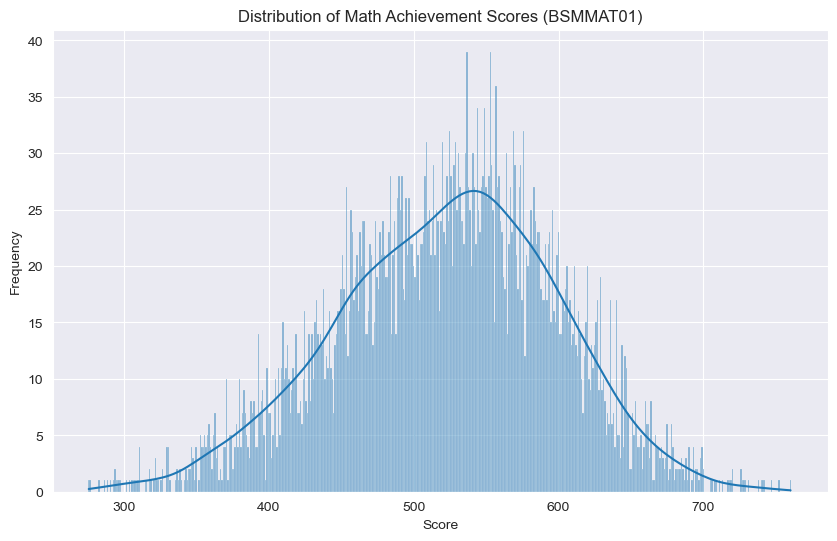

In [31]:
plt.figure(figsize=(10, 6))
sns.histplot(df_ach['BSMMAT01'], kde=True)
plt.title('Distribution of Math Achievement Scores (BSMMAT01)')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

I've identified the math achievement variables, which are named BSMMAT01 through BSMMAT05. These are the five "plausible values" of math achievement for each student. I've checked their basic statistics and visualized the distribution of the first plausible value (BSMMAT01).

# Now i'll identify variables from the student background data that might be useful predictors of math achievement.

In [39]:
print(df_bg.columns.tolist())

['CTY', 'IDCNTRY', 'IDPOP', 'IDGRADER', 'IDGRADE', 'ITASSESS', 'IDBOOK', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'ITSEX', 'BSDAGE', 'ITADMINI', 'ILRELIAB', 'ITLANG_SQ', 'LCID_SQ', 'BSBG01', 'BSBG03', 'BSBG04', 'BSBG05A', 'BSBG05B', 'BSBG05C', 'BSBG05D', 'BSBG05E', 'BSBG05F', 'BSBG05G', 'BSBG05H', 'BSBG05I', 'BSBG05J', 'BSBG06A', 'BSBG06B', 'BSBG07', 'BSBG08A', 'BSBG08B', 'BSBG09A', 'BSBG09B', 'BSBG10', 'BSBG11A', 'BSBG11B', 'BSBG12A', 'BSBG12B', 'BSBG12C', 'BSBG12D', 'BSBG12E', 'BSBG12F', 'BSBG13A', 'BSBG13B', 'BSBG13C', 'BSBG13D', 'BSBG13E', 'BSBG13F', 'BSBG13G', 'BSBG14A', 'BSBG14B', 'BSBG14C', 'BSBG14D', 'BSBG14E', 'BSBG14F', 'BSBG14G', 'BSBG14H', 'BSBG14I', 'BSBG15A', 'BSBG15B', 'BSBG15C', 'BSBG15D', 'BSBG15E', 'BSBG15F', 'BSBG16A', 'BSBG16B', 'BSBG16C', 'BSBG16D', 'BSBG16E', 'BSBG16F', 'BSBG16G', 'BSBG16H', 'BSBG17A', 'BSBG17B', 'BSBG17C', 'BSBG17D', 'BSBG17E', 'BSBG17F', 'BSBG17G', 'BSBG17H', 'BSBG17I', 'BSBG17J', 'BSBG17K', 'BSBG17L', 'BSBG17M', 'BSBG17N', 'BSBM18', 'BSBM19A', 'BSBM19B

In [40]:
potential_predictors = [
    'BSBG01',    # Student gender
    'BSBG04',    # Number of books in home
    'BSDGEDUP',  # Parents' highest education level
    'BSBGSLM',   # Student likes math
    'BSBGSCM',   # Student confident in math
    'BSBGSB'     # Sense of school belonging
]

These predictors are based on TIMSS documentation and research.

# Display value counts for a couple of these variables

In [36]:
print("\nGender distribution:")
print(df_bg['BSBG01'].value_counts(dropna=False))


Gender distribution:
BSBG01
Boy        2583
Girl       2283
<Other>     177
NaN          47
Name: count, dtype: int64


In [41]:
print("\nNumber of books in home:")
print(df_bg['BSBG04'].value_counts(dropna=False).sort_index())


Number of books in home:
BSBG04
Enough to fill one bookcase (26–100 books)                1480
Enough to fill one shelf (11–25 books)                     996
Enough to fill three or more bookcases (more than 200)     830
Enough to fill two bookcases (101–200 books)               950
None or very few (0–10 books)                              778
NaN                                                         56
Name: count, dtype: int64


# Merge achievement and background data

In [46]:
merged_data = pd.merge(
    df_ach,
    df_bg,
    on="IDSTUD",  # Student ID is the common key
    how="inner",
    suffixes=('_ach', '_bg')
)

print(f"Merged data shape: {merged_data.shape}")

Merged data shape: (5090, 1655)


Here we can see 5090 students after merging.

## Create a target variable as the average of all plausible values

In [54]:
math_vars = [col for col in merged_data.columns if col.startswith('BSMMAT') and col.endswith('_ach')]
print(f"Math score variables: {math_vars}")


Math score variables: ['BSMMAT01_ach', 'BSMMAT02_ach', 'BSMMAT03_ach', 'BSMMAT04_ach', 'BSMMAT05_ach']


In [55]:
merged_data['math_score'] = merged_data[math_vars].mean(axis=1)
print("\nBasic statistics of average math score:")
print(merged_data['math_score'].describe())


Basic statistics of average math score:
count    5090.000000
mean      523.604135
std        74.407261
min       268.910408
25%       474.095008
50%       527.223925
75%       575.779497
max       753.278594
Name: math_score, dtype: float64


In [56]:
# Check for missing values
missing_data = model_data.isnull().sum()
missing_percent = (missing_data / len(model_data)) * 100
    missing_info = pd.DataFrame({
        'Missing Values': missing_data,
        'Percent Missing': missing_percent
    })
    print("\nMissing values in key features:")
    print(missing_info[missing_info['Missing Values'] > 0].sort_values('Missing Values', ascending=False))

IndentationError: unexpected indent (1263514521.py, line 2)